# Statistical Analysis Summary


In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections
from pprint import pprint
from natsort import natsorted

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne

mne.utils.use_log_level('error')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import pingouin as pg
import dabest
from hyppo.independence import MGC
from hyppo.ksample import KSample

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_resected_chs(subject, root):
    bids_path = BIDSPath(subject=subject, root=root,
                         suffix='channels', extension='.tsv')
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
    description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
    resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
    return resected_chs

In [4]:
def load_concat_derivs(deriv_path, subject, session, desc, tasks=None):
    # get all the subject/sessions in the derivative path
    subjects = get_entity_vals(deriv_path, 'subject')
    ignore_subjects = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
    ignore_sessions = [ses for ses in sessions if ses != session]

    # store all derivatives found in a list
    derivs = []
    onsets = []
    descriptions = []
    prevlen = 0
    
    if session == 'extraoperative':
        tasks = ['interictal', 'ictal']
        
    if tasks is None:
        # get all the tasks associated if not passed in
        tasks = get_entity_vals(deriv_path, 'task', 
                            ignore_subjects=ignore_subjects,
                            ignore_sessions=ignore_sessions
                           )
    for task in tasks:
        # get all file paths for this subject
        search_str = f'*ses-{session}*task-{task}*desc-{desc}*.json'
        deriv_fpaths = natsorted(list((deriv_path / f'sub-{subject}').glob(search_str)))

#         print(f'Found {len(deriv_fpaths)} derivative file paths')

        for idx, deriv_fpath in enumerate(deriv_fpaths):
            deriv = read_derivative_npy(deriv_fpath, preload=True, 
                                        verbose=False)

            if 'ch_axis' not in deriv.info:
                deriv.info['ch_axis'] = [0]
                rowderiv.info['ch_axis'] = [0 ]

            # create derivative structure
            onsets.append(prevlen + len(deriv))
            descriptions.append(f'ses-{session}-task-{task}-run-{idx+1}')
            prevlen += len(deriv)
    #         if derivative is None:
    #             derivative = deriv.copy()
    #             derivs.append(deriv.copy())
    #         else:
                # check that all channel names are ordered
    #                 if derivative.ch_names != deriv.ch_names:
    #                     deriv.reorder_channels(derivative.ch_names)
    #                     rowderiv.reorder_channels(derivative.ch_names)
    #                 assert derivative.ch_names == deriv.ch_names
    #                 derivative.append(deriv.copy())
            derivs.append(deriv.copy())
    return derivs, onsets, descriptions

In [5]:
def compute_baseline(subject, deriv_root, deriv_chain, task, desc='perturbmatrix'):
    # load interictal snapshots only if available
    deriv_path = Path(deriv_root) / deriv_chain
    deriv_fpath = list(deriv_path.rglob(f'sub-{subject}*_task-{task}*_run-01*_desc-{desc}*.json'))
    if len(deriv_fpath) == 0:
        return None, None
    elif len(deriv_fpath) > 1:
        raise RuntimeError(f'Found more then one file {deriv_fpath}...')
    else:
        deriv_fpath = deriv_fpath[0]
    
    # read in the file
    deriv = read_derivative_npy(deriv_fpath, preload=True)
    deriv.normalize()
    deriv_data = deriv.get_data()
    
    # create mean and std vector
    mean_vec = deriv_data.mean(axis=1)
    std_vec = deriv_data.std(axis=1)
    
    return mean_vec, std_vec

In [6]:
def generate_deriv_list(derivs, rowderivs):
    derivative = None
    new_derivs = []

    # loop through each derivative
    for deriv, rowderiv in zip(derivs, rowderivs):
        deriv.normalize()
        rowderiv.normalize()

        coldata = deriv.get_data()
        rowdata = rowderiv.get_data()

        # combine the data if wanted
    #     data = np.abs(coldata - rowdata)
        data = coldata.copy()
    #     data = rowdata.copy()

        # re-create a new derivative
        new_deriv = DerivativeArray(data, info=deriv.info)

        if derivative is None:
            # subtract baseline vector from each time point
    #         data = data - mean_vec[:, np.newaxis]
    #         new_deriv = DerivativeArray(data, info=deriv.info)

            derivative = new_deriv.copy()
        else:
            if not all([ch in deriv.ch_names for ch in derivative.ch_names]):
                # get the set difference of channels
                add_chs = list(set(derivative.ch_names) - set(deriv.ch_names))
                ch_type = derivative.get_channel_types()[0]
                info = create_deriv_info(ch_names=add_chs, sfreq=derivative.info['sfreq'], 
                                         ch_types=ch_type, 
                                         description=derivative.description,
                                        ch_axis=[0])
                addderiv = DerivativeArray(np.ones((len(add_chs), len(deriv)))*-1, info=info, verbose=False)

                # add derivative chs
                new_deriv = new_deriv.add_channels([addderiv])

            if derivative.ch_names != new_deriv.ch_names:
                # add channels and reorder if necessary
                new_deriv.reorder_channels(derivative.ch_names)

    #             nonrz_inds = [idx for idx, ch in enumerate(new_deriv.ch_names) 
    #                          if ch not in add_chs]
    #             data = new_deriv.get_data()
    #             info = new_deriv.info
    #             data[nonrz_inds, :] = data[nonrz_inds, :] - mean_vec[nonrz_inds, np.newaxis]
    #             new_deriv = DerivativeArray(data, info=info)
            else:
                # subtract baseline vector from each time point
    #             data = data - mean_vec[:, np.newaxis]
                new_deriv = DerivativeArray(data, info=deriv.info)

            derivative.append(new_deriv)                  
        new_derivs.append(new_deriv)
    return new_derivs                   

In [7]:
def compute_block_bootstrap_stats(pre_deriv, post_deriv, df_summ=None, threshold=None):
    # compute effect size difference with sub-sampling
    pre_blocks = pre_deriv.subsample_blocks()
    post_blocks = post_deriv.subsample_blocks()

    cohensd = []
    stats = []
    pvals = []

    for preb, postb in zip(pre_blocks, post_blocks):
        if threshold is not None:
            preb[preb < threshold] = np.nan
            postb[postb < threshold] = np.nan

        # drop any nans
        preb = preb[~np.isnan(preb)]
        postb = postb[~np.isnan(postb)]

        stat, pvalue = KSample("Dcorr").test(preb, postb)
        stats.append(stat)
        pvals.append(pvalue)

        es = pg.compute_effsize(preb, postb, 
                                paired=False, eftype='cohen')

        cohensd.append(es)
        
        if df_summ is not None:
            df_summ.append([subject, es, stat, pvalue])
    return cohensd, stats, pvals

# Initialize dataframe for plotting over all subjects

In [40]:
# keep track of the dataframe summary
df = pd.DataFrame()

# Load data for all subjects

In [41]:
# paths to BIDS dataset / derivatives
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'

# derivative experiment markers
reference = 'monopolar'
sampling_res = '1000Hz'  # 'originalsampling'
deriv_chain = Path(sampling_res) / 'radius1.25' / 'fragility' / reference
deriv_path = deriv_root / deriv_chain

# where to save the data
figures_path = deriv_root / 'figures'

# all session to analyze
sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']

# the derivative ``desc`` entity description
desc = 'perturbmatrix'
rowdesc = 'rowperturbmatrix'

In [42]:
# get all subjects analyze
subjects = get_entity_vals(deriv_path, 'subject')

print(f'All subjects analyzed are: {subjects}')

All subjects analyzed are: ['E1', 'E3', 'E4', 'E5', 'E6', 'E7']


In [45]:
featurename = 'Col Fragility'
# featurename = 'Row Fragility'
# featurename = 'Absolute Fragility'

# cbarlabel = 'Absolute Diff Fragility'
cbarlabel = 'Col Fragility'
# cbarlabel = 'Row Fragility'

threshold = 0.45

In [46]:
for subject in subjects:
    # get list of sessions for subject
    ignore_subjects = [sub for sub in subjects if sub != subject]
#     sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
    sessions = ['extraoperative', 'preresection', 'intraresection', 'postresection']
    print(f'Sessions in the deriv path {sessions}')
    
    # compute the channel's mean row perturbation values during interictal awake periods
    # as a baseline
    mean_vec, std_vec = compute_baseline(subject, deriv_root, deriv_chain,
                                     task='interictalawake', desc='rowperturbmatrix')

    # load all the column perturbation derivatives
    derivs = []
    onsets = []
    descriptions = []
    
    # keep track of data frame summary statistics
    df_summ = []

    for session in sessions:
        print(session)
        derivs_, onsets_, descrips_ = load_concat_derivs(deriv_path, subject, session, 
                                    desc='perturbmatrix')
        derivs.extend(derivs_)
        onsets.extend(onsets_)
        descriptions.extend(descrips_)
    
    # load all the row perturbation derivatives
    rowderivs = []
    for session in sessions:
        print(session)
        derivs_, _, _ = load_concat_derivs(deriv_path, subject, session, 
                                    desc='rowperturbmatrix')
        rowderivs.extend(derivs_)
    print(len(rowderivs))
    
    # create list of all the onset times 
    onsets = []
    prevonset = 0
    for deriv in derivs:
        onsets.append(len(deriv) + prevonset)
        prevonset += len(deriv)
        
    # read in the resected channels for the dataset
    bids_path = BIDSPath(subject=subject, root=root,
                     suffix='channels', extension='.tsv')
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
    description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
    resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
    resected_inds = [idx for idx, ch in enumerate(deriv.ch_names) if ch in resected_chs]
    nrz_inds = [idx for idx in range(len(deriv.ch_names)) if idx not in resected_inds]
    
    # generate concatenated list of derivatives
    derivlist = generate_deriv_list(derivs, rowderivs)
    
    # only get the pre/post resection data
    pre_deriv = [deriv for deriv in derivs if 'task-pre' in deriv.filenames[0]][0]
    post_deriv = [deriv for deriv in derivs if 'task-post' in deriv.filenames[0]][0]

    pre_data = pre_deriv.get_data()
    post_data = post_deriv.get_data()
    print(pre_data.shape, post_data.shape)
    
    # compute block-bootstrap statistics
    cohensd, stats, pvals = compute_block_bootstrap_stats(pre_deriv, post_deriv, 
                                                          df_summ=df_summ, threshold=threshold)
    
    # create 
    subj_df = pd.DataFrame(df_summ, columns=['subject', 'es', 'stat', 'pval'])
    if df.empty:
        df = subj_df
    else:
        df = pd.concat((df, subj_df), axis=0)

display(subj_df.head())
print(df.shape, subj_df.shape)

Sessions in the deriv path ['extraoperative', 'preresection', 'intraresection', 'postresection']
<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | rowperturbmatrix>
extraoperative
preresection
intraresection
postresection
extraoperative
preresection
intraresection
postresection
9
<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalasleep_acq-ecog_run-01_desc-perturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | perturbmatrix>
<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalasleep_acq-ecog_run-01_desc-rowperturbmatrix_ieeg.npy, shape: (98, 1205) (98 chs x 1205 times) (301.0 s), ~1.1 MB, data loaded | reference=monopolar | rowperturbmatrix>
<DerivativeNumpy | sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.n

,subject,es,stat,pval
0,E7,0.253199,0.012308,0.013935
1,E7,0.505748,0.051714,0.000003
2,E7,0.098035,0.000535,0.270969
3,E7,0.086594,0.001340,0.207962
4,E7,0.324077,0.016993,0.004632


(900, 4) (100, 4)


In [47]:
for subject in subjects:
    print(subject)
    display(df[df['subject'] == subject].describe())

E1


,es,stat,pval
count,200.000000,200.000000,2.000000e+02
mean,-0.418105,0.038433,9.749405e-04
std,0.122485,0.020689,6.661656e-03
min,-0.730805,0.002424,2.947331e-20
25%,-0.509127,0.021429,9.732275e-10
50%,-0.414391,0.035160,2.921350e-07
75%,-0.324005,0.051685,3.867506e-05
max,-0.129229,0.111290,8.924300e-02


E3


,es,stat,pval
count,200.000000,200.000000,2.000000e+02
mean,0.381538,0.034742,1.254887e-01
std,0.264465,0.037243,2.252371e-01
min,-0.312458,-0.006746,3.269844e-16
25%,0.188867,0.005493,4.711151e-04
50%,0.380021,0.023906,1.564875e-02
75%,0.533537,0.051530,1.350533e-01
max,1.187993,0.199640,1.000000e+00


E4


,es,stat,pval
count,200.000000,200.000000,2.000000e+02
mean,0.551293,0.037452,6.843055e-02
std,0.277539,0.027988,1.952880e-01
min,-0.197931,-0.005621,1.099534e-10
25%,0.382873,0.017196,5.875766e-05
50%,0.558449,0.032667,2.017652e-03
75%,0.752720,0.058088,2.030403e-02
max,1.075200,0.165187,1.000000e+00


E5


,es,stat,pval
count,100.000000,100.000000,1.000000e+02
mean,0.581996,0.045049,6.495121e-02
std,0.237354,0.033936,1.448424e-01
min,-0.228898,-0.008560,9.904542e-07
25%,0.464213,0.018128,7.003673e-04
50%,0.594472,0.039061,8.457188e-03
75%,0.737617,0.071895,4.944375e-02
max,1.283961,0.149915,8.345304e-01


E6


,es,stat,pval
count,100.000000,100.000000,1.000000e+02
mean,-0.040173,0.017740,2.160065e-01
std,0.336859,0.030513,2.846738e-01
min,-0.988859,-0.005052,1.412710e-11
25%,-0.294271,-0.000582,4.718064e-03
50%,-0.003612,0.006655,7.479986e-02
75%,0.204282,0.023794,3.597190e-01
max,0.623546,0.186827,1.000000e+00


E7


,es,stat,pval
count,100.000000,100.000000,1.000000e+02
mean,0.343600,0.026215,5.773896e-02
std,0.166421,0.021471,1.389066e-01
min,-0.052332,-0.001581,2.128109e-12
25%,0.215715,0.009061,3.404832e-06
50%,0.336892,0.020178,8.629129e-04
75%,0.465626,0.040952,2.208855e-02
max,0.756656,0.090736,7.587970e-01


done


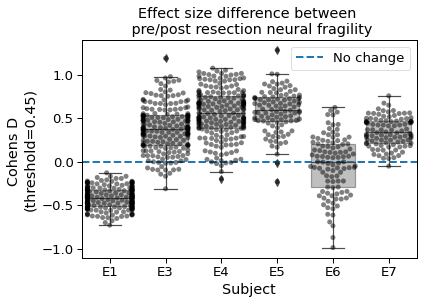

In [48]:
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots()
sns.swarmplot(x='subject', y='es',
              order=natsorted(df['subject'].unique()),
              alpha=0.5, color='black',
              data=df, ax=ax)
sns.boxplot(x='subject', y='es', color='gray',
            order=natsorted(df['subject'].unique()), 
            data=df, ax=ax, boxprops=dict(alpha=0.5))

# plot horizontal line
ax.axhline([0], ls='--', lw=2, label='No change')

ax.legend()
ax.set(
    xlabel='Subject',
    ylabel=f'Cohens D \n(threshold={threshold})',
    title='Effect size difference between \n pre/post resection neural fragility'
)
print('done')

In [49]:
# fig, ax = plt.subplots()
# sns.swarmplot(x='subject', y='pval',
#               order=natsorted(df['subject'].unique()),
#               alpha=0.5,
#               data=df, ax=ax)
# sns.boxplot(x='subject', y='pval', 
#             order=natsorted(df['subject'].unique()), 
#             data=df, ax=ax, boxprops=dict(alpha=0.5))

# ax.set(
#     yscale='log',
#     xlabel='Subject',
#     ylabel='Pvalue',
#     title='Nonparametric MANOVA pvalue between \n pre/post resection neural fragility'
# )